In [10]:
# %%
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
from scipy.io import loadmat
from torch.distributions import MultivariateNormal, Poisson
from cutbayesflow import CutBayesFlow, train_cut_bayes_flow
from cutbayesflow.utils import get_marginal_samples

# Get directory of current script
base_dir = os.getcwd()

# ─────────────────────────────────────────────────────────────
# 1) Load and Prepare Data
# ─────────────────────────────────────────────────────────────
torch.manual_seed(1010)
np.random.seed(627)

# Load second module data (Y21, Y22)
Y21_np = np.array([16, 215, 362, 97, 76, 62, 710, 56, 133, 28, 62, 413, 194]).reshape(1, -1)
Y22_np = np.array([26983, 250930, 829348, 157775, 150467, 352445, 553066, 26751, 75815, 150302, 354993, 3683043, 507218]).reshape(1, -1)

Y21 = torch.tensor(Y21_np, dtype=torch.float32)
Y22 = torch.tensor(Y22_np, dtype=torch.float32) / 1000  # Scale for numerical stability

# Load first module samples (theta1_samples)
theta1_path = os.path.join(base_dir, "stage1", "theta1_samples.mat")
data = loadmat(theta1_path)
theta1_samples = torch.tensor(data['theta1'], dtype=torch.float32)
n_samples, latent_dim = theta1_samples.shape  # (1000, 13)

# Broadcast Y21, Y22 to match theta1_samples
Y21 = Y21.repeat(n_samples, 1)  # shape: [1000, 13]
Y22 = Y22.repeat(n_samples, 1)

# Bundle second module data for likelihood
data_D2 = {
    "Y21": Y21,
    "Y22": Y22
}

# ─────────────────────────────────────────────────────────────
# 2) Define Prior and Likelihood Functions
# ─────────────────────────────────────────────────────────────
def prior_log_prob_fn(theta2):
    """
    Prior: Multivariate Normal N(0, 1000*I)
    """
    prior_std = torch.sqrt(torch.tensor(1000.0))
    prior = MultivariateNormal(loc=torch.zeros(2), covariance_matrix=torch.eye(2) * prior_std**2)
    return prior.log_prob(theta2)

def likelihood_log_prob_fn(theta2, theta1, data):
    """
    log p(Y21 | theta2, theta1) where
    Y21 ~ Poisson(exp(beta + gamma * theta1))
    """
    Y21, Y22 = data["Y21"], data["Y22"]

    beta = theta2[:, 0:1]   # shape: [N, 1]
    gamma = theta2[:, 1:2]  # shape: [N, 1]
    linear_predictor = beta + gamma * theta1  # shape: [N, 13]
    poisson_lambda = torch.exp(linear_predictor)  # shape: [N, 13]

    log_likelihood = Y21 * linear_predictor - Y22 * poisson_lambda - torch.lgamma(Y21 + 1)
    return log_likelihood.sum(dim=1)  # shape: [N]

# ─────────────────────────────────────────────────────────────
# 3) Initialize CutBayesFlow Model
# ─────────────────────────────────────────────────────────────
model = CutBayesFlow(
    prior_log_prob_fn=prior_log_prob_fn,
    likelihood_log_prob_fn=likelihood_log_prob_fn,
    eta_dim=latent_dim,
    theta_dim=2,  # beta, gamma
    num_layers=4,
    hidden_features=64,
    num_bins=10,
    tail_bound=30.0
)

# ─────────────────────────────────────────────────────────────
# 4) Train the Model
# ─────────────────────────────────────────────────────────────
print("Training CutBayesFlow on HPV real data...")
start_time = time.time()

loss_history = train_cut_bayes_flow(
    model=model,
    eta_samples=theta1_samples,
    data_D2=data_D2,  # Pass second module data cleanly
    epochs=5000,
    lr=0.005,
    patience=200,
    seed=402,
    verbose=200  # Print every 200 steps
)

print(f"Training completed in {time.time() - start_time:.2f} seconds")


Training CutBayesFlow on HPV real data...
⚡ Using full-batch mode with batch_size=1000
Step     0 | Loss: 918190720.000000
Step   100 | Loss: 13157.458984
Step   200 | Loss: 12994.423828
Step   300 | Loss: 13164.012695
Step   400 | Loss: 13071.151367
Step   500 | Loss: 13067.099609
Step   600 | Loss: 13076.734375
Step   700 | Loss: 13044.835938
Step   800 | Loss: 13031.871094
Step   900 | Loss: 12974.991211
Step  1000 | Loss: 13041.435547
Step  1100 | Loss: 13034.005859
Step  1200 | Loss: 13042.934570
Step  1300 | Loss: 13046.066406
Step  1400 | Loss: 13095.589844
Step  1500 | Loss: 13049.983398
Step  1600 | Loss: 13028.462891
Step  1700 | Loss: 12987.295898
Step  1800 | Loss: 12985.390625
Step  1900 | Loss: 13064.725586
Step  2000 | Loss: 13096.325195
Step  2100 | Loss: 13028.950195
Step  2200 | Loss: 13018.987305
Step  2300 | Loss: 13018.830078
Step  2400 | Loss: 13044.212891
Step  2500 | Loss: 13051.807617
Step  2600 | Loss: 13048.452148
Step  2700 | Loss: 13041.057617
Step  2800 | 

Text(0, 0.5, 'Loss')

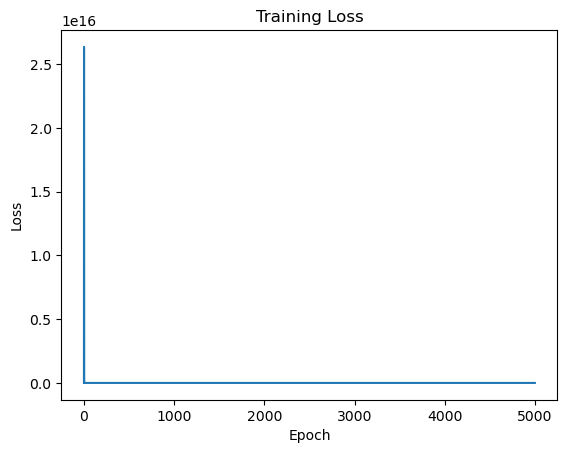

In [11]:
# Plot Loss
plt.plot(loss_history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

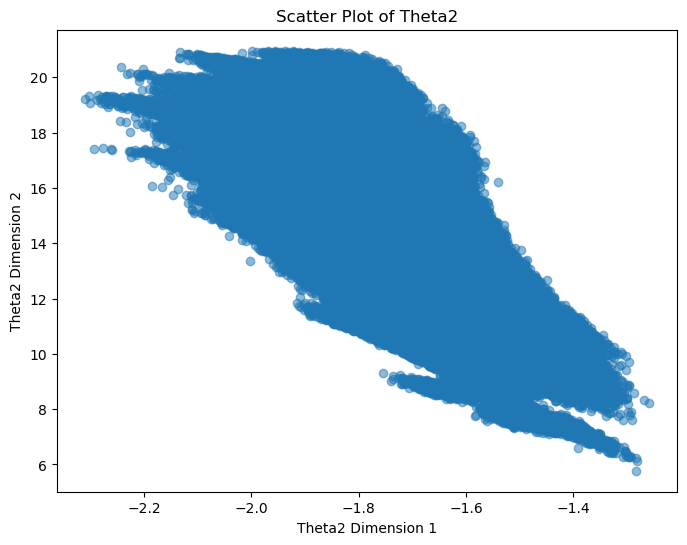

In [12]:
# ─────────────────────────────────────────────────────────────
# 5) Post-Training Sampling
# ─────────────────────────────────────────────────────────────
n_iterations = 1000
theta2_samples = get_marginal_samples(model, theta1_samples, n_iterations=n_iterations)
theta2_samples_flat = theta2_samples.cpu().reshape(-1, 2).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(theta2_samples_flat[:, 0], theta2_samples_flat[:, 1], alpha=0.5)
plt.xlabel('Theta2 Dimension 1')
plt.ylabel('Theta2 Dimension 2')
plt.title('Scatter Plot of Theta2')
plt.show()
